## Explaining How a Deep Neural Network Trained with End-to-End Learning Steers a Car

The main idea is to show which part of the image guide the network to take a decision. It's implemented by grabing activations for the network, merging them and scaling back to the original size.

References:
* https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
* http://www.nvidia.com/object/drive-px.html
* https://arxiv.org/pdf/1604.07316.pdf
* https://arxiv.org/pdf/1704.07911v1.pdf
* https://www.youtube.com/watch?v=2TT1EKPV_hc
* http://stackoverflow.com/questions/34975972/how-can-i-make-a-video-from-array-of-images-in-matplotlib
* http://stackoverflow.com/questions/4092927/generating-movie-from-python-without-saving-individual-frames-to-files
* https://www.reddit.com/r/IPython/comments/35tocn/is_it_possible_to_embed_a_local_file_video_in_the/

In [1]:
import tensorflow as tf
import scipy.misc
import sys
sys.path.append('../')
import model
from subprocess import call
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

folder_dataset = "../Track6_Wheel/"

### Load tensorflow model at specific point

In [2]:
driving_model = model.DrivingModelAutoEncoder()
# Get placeholders from model
model_in = driving_model.input
model_out = driving_model.output
# Load tensorflow section
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "../save_autoencoder/model-227")

INFO:tensorflow:Restoring parameters from ../save_autoencoder/model-227


### Grab one image

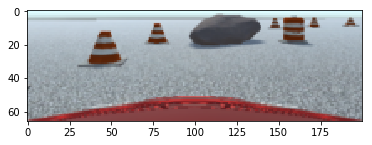

In [3]:
full_image = scipy.misc.imread(folder_dataset + "438" + ".png", mode="RGB")

# Do the same transformation that is expected by the model
image = scipy.misc.imresize(full_image[-130:], [66, 200]) / 255.0

plt.imshow(image)
plt.show()

### Evalulate Convolutional Auto-encoder

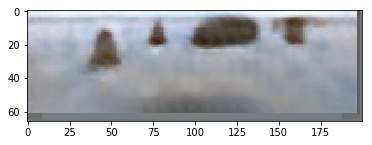

In [4]:
img_out = model_out.eval(feed_dict={model_in: [image]})
img_out = np.squeeze(img_out)
plt.imshow(img_out)
plt.show()

## Grab the activations and merge them
![Diagram](NvidiaSalient.png)

### Grab some activations from model

In [5]:
# We still don't know how to grab the results from the last prediction....
conv5act = driving_model.conv5.eval(feed_dict={model_in: [image]})
conv4act = driving_model.conv4.eval(feed_dict={model_in: [image]})
conv3act = driving_model.conv3.eval(feed_dict={model_in: [image]})
conv2act = driving_model.conv2.eval(feed_dict={model_in: [image]})
conv1act = driving_model.conv1.eval(feed_dict={model_in: [image]})

# Another way
# Grab activations
#conv5act, conv4act, conv3act, conv2act, conv1act = sess.run(
#    [model.conv5, model.conv4, model.conv3, model.conv2, model.conv1], 
#    feed_dict={model.x: [image], model.dropout_prob: 1.0})

# check shapes
print(conv5act.shape)
print(conv4act.shape)
print(conv3act.shape)
print(conv2act.shape)
print(conv1act.shape)

(1, 1, 18, 64)
(1, 3, 20, 64)
(1, 5, 22, 48)
(1, 14, 47, 36)
(1, 31, 98, 24)


### Average each layers activations

In [6]:
# Get the mean, and supress the first(batch) dimension
averageC5 = np.mean(conv5act,axis=3).squeeze(axis=0)
averageC4 = np.mean(conv4act,axis=3).squeeze(axis=0)
averageC3 = np.mean(conv3act,axis=3).squeeze(axis=0)
averageC2 = np.mean(conv2act,axis=3).squeeze(axis=0)
averageC1 = np.mean(conv1act,axis=3).squeeze(axis=0)

# check shapes
print(averageC5.shape)
print(averageC4.shape)
print(averageC3.shape)
print(averageC2.shape)
print(averageC1.shape)

(1, 18)
(3, 20)
(5, 22)
(14, 47)
(31, 98)


### Upscale and mult on all layers

In [ ]:
# Play here to select a single activation map
multC12up = scipy.misc.imresize(averageC5,[image.shape[0], image.shape[1]])

In [7]:
averageC5up = scipy.misc.imresize(averageC5,[averageC4.shape[0], averageC4.shape[1]])
multC45 = np.multiply(averageC5up,averageC4)
multC45up = scipy.misc.imresize(multC45,[averageC3.shape[0], averageC3.shape[1]])
multC34 = np.multiply(multC45up,averageC3)
multC34up = scipy.misc.imresize(multC34,[averageC2.shape[0], averageC2.shape[1]])
multC23 = np.multiply(multC34up,averageC2)
multC23up = scipy.misc.imresize(multC23,[averageC1.shape[0], averageC1.shape[1]])
multC12 = np.multiply(multC23up,averageC1)
multC12up = scipy.misc.imresize(multC12,[image.shape[0], image.shape[1]])

### Normalise between 0 and 1

In [8]:
salient_mask = (multC12up - np.min(multC12up))/(np.max(multC12up) - np.min(multC12up))

### Show mask over the image
Observe that the borders of the road, and lane markings are important to decide what to do.
![Diagram](ReferencePaper.png)

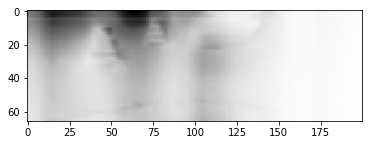

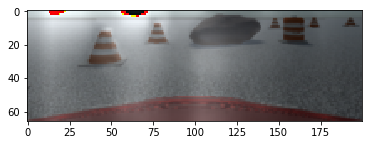

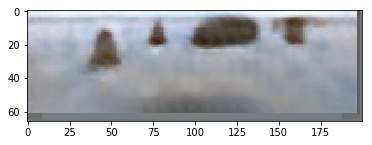

In [9]:
# Show the salient mask
plt.imshow(salient_mask, cmap=plt.get_cmap('Greys'))
plt.show()

# Create 3 dimensions on the salient_mask
salient_mask_stacked = np.dstack((salient_mask,salient_mask))
salient_mask_stacked = np.dstack((salient_mask_stacked,salient_mask))

blendImg = (0.4*image) + (0.7 * salient_mask_stacked)
plt.imshow(blendImg)
plt.show()

plt.imshow(img_out)
plt.show()